In [1]:
import pandas as pd
import numpy as np
import os
import json
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import adjusted_mutual_info_score, mutual_info_score
import hdbscan
import matplotlib.pyplot as plt

from data_prep_scripts.data_countries import get_country_of_origin_data 
from data_prep_scripts.data_manipulation import df_replaceColVals_vars,process_remaining_categ_cols, read_enum_dict
from data_prep_scripts.process_repetitive_cols import get_repetitive_cols

## Load and preprocess raw data

In [2]:
# column we predict
col_to_predict = 'Triple Negative'
# preparing the df containing the raw data
medData = pd.read_excel('Merged File 2.5.19 De-identified.xlsx')
medData['Country of Origin for Father'].replace(76,'Ireland',inplace=True)
medData = medData[(medData['Breast Cancer?']=='Yes') & (medData['Gender'] == 'Female')]
medData = medData.applymap(lambda s:s.lower() if type(s) == str else s)
predCol = pd.read_excel('Additional BCD Info 3.1.19 De-identified.xlsx',usecols="A,DZ")
medData = medData.merge(predCol,left_on='ID #', right_on='ID #')
medData = medData[medData[col_to_predict]!='Unknown']

In [3]:
recurrenceData = pd.read_excel('Additional BCD Info 3.1.19 De-identified.xlsx',usecols="A,US")
recurrenceData['recurrence'] = ~recurrenceData['Type of Recurrence'].isna()

In [4]:
ind_repititive_blocks = [
    (47,89,7),(89,117,7),(117,152,7),
    (163,191,7),(197,213,4),(214,249,5),
    (294,348,6),(349,356,7),(357,364,7),
    (427,435,8)
]
ind_not_del = list(range(22,43)) + [274]
ind_to_del = [2,3,4,(8,11),13,451,(197,213),(349,356),(386,414),(448,469)]

In [5]:
# processes blocks of columns that contain the same type of information
# groups them and returns them in lists.
rep_cols = get_repetitive_cols(medData)
# remove empty blocks and replace block[1] with an empty list
# if there is no cont. element
rep_cols_np = [
    [
        (block[0].astype('int64').values, block[1].astype('float32').values)
        if isinstance(block[1],pd.DataFrame) and block[1].shape[1]>0 
        else (block[0].astype('int64').values,[]) for block in group  if block
    ] 
    for group in rep_cols
] 

In [6]:
# get features for country of origin columns
country_of_origin_data = get_country_of_origin_data(medData)

In [7]:
# mixed_cols=[]
# for ii, (a,b) in enumerate(medData.dtypes.iteritems()):
#     if b == object:
#         types = set([type(k) for k in list(medData[a].dropna() ) ])
#         if str in types and len(types)>1: 
#             print(ii,a,b)

In [8]:
# columns that should only contain real numbered values, but contain strings in the raw data.
# this part of the code saves such string values in a json file, where we can specify
# the values to replace them with.
mixedCols_write_strs = [92,121,126,131,136,141,146,151,152,192,294,303,416,417,418,446,449]
dict_replaceColVals = df_replaceColVals_vars(medData,mixedCols_write_strs,str_vals=True)

In [9]:
medData.replace(dict_replaceColVals,inplace=True)

In [10]:
# replace outlier values with the values given in the json file
# where we can specify the values to replace them with
dict_replaceColVals_cont = df_replaceColVals_vars(medData,str_vals=False, cont_vals=True)
for k,v in dict_replaceColVals_cont.items():
    k_l, v_l = [], []
    for key, val in v.items():
        k_l.append(float(key)); v_l.append(val)
    medData[k].replace(k_l,v_l,inplace=True)
        

/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
col_min_max_count = 250
val_count_threshold = 50
col_values_replace_OTH = defaultdict(lambda:[])
cols_to_del=[]
for c in ind_to_del: 
    if isinstance(c,tuple): cols_to_del += list(medData.columns[c[0]:c[1]])
    else: cols_to_del.append(medData.columns[c])

for ii, (a,b) in enumerate(medData.dtypes.iteritems()):
    # do not delete the column in repetitive blocks
    in_rep_block = False
    for block in ind_repititive_blocks: 
        if (ii>=block[0]) and (ii < block[1]): in_rep_block = True
            
    if (not in_rep_block) and (b == object) and (ii not in ind_not_del):
        col_counts = medData[a].value_counts()        
        col_max_count = col_counts.iloc[0]
        # the most frequent value of a column should occur at least 'col_min_max_count' times
        if col_max_count < col_min_max_count: cols_to_del.append(a)
        elif medData.shape[0]-col_max_count < col_min_max_count: cols_to_del.append(a)
#         # for the columns that we preserve, we replace values if their 
#         # frequency is not above the given threshold 'val_count_threshold'.
#         else:
#             vals_to_OTH = list(col_counts[col_counts<val_count_threshold].index)
#             if vals_to_OTH: 
#                 col_values_replace_OTH[a] = vals_to_OTH
# print(len(col_values_replace_OTH.keys()))
# print(col_values_replace_OTH.keys())
# print(len(cols_to_del))
# print(cols_to_del)

In [12]:
# I deleted the datetime values for now. Will be added in the next iterations.
cols_to_del += list(medData.select_dtypes(include=['datetime']))
# cols processed by the 'get_repetitive_cols()' function
cols_repetitive = sum([list(medData.columns[c[0]:c[1]]) for c in ind_repititive_blocks],[])


In [13]:
remaining_obj_cols = [
    k for k in medData.select_dtypes(include=['object']) 
        if (k not in cols_to_del + cols_repetitive +[col_to_predict]) and 
           (not medData[k].isnull().all() )    
]
remaining_float_cols = [
    k for k in medData.select_dtypes(include=['float64']) 
        if (k not in cols_to_del + cols_repetitive +[col_to_predict]) and 
           (not medData[k].isnull().all() )    
]

In [14]:
medData_categ = process_remaining_categ_cols(medData[remaining_obj_cols])
medData_float = medData[remaining_float_cols]

In [15]:
#rep_cols
#country_of_origin_data

In [16]:
# for i,k in enumerate(medData.columns):
#     if k in remaining_obj_cols: print(i)

## Create model's inputs

In [17]:
# training and validation splits (80% and 20% respectively)
n_patients = medData.shape[0]
temp_indices = np.arange(n_patients)
np.random.seed(0)
np.random.shuffle(temp_indices)
train_ind, valid_ind = [
    temp_indices[ int(n_patients*c[0]):int(n_patients*c[1]) ]
    for c in [(0,0.8), (.8,1.)]
]

Single, unique columns

In [18]:
# floats
float_fields_scaler = StandardScaler()
float_fields_scaler.fit(medData_float.iloc[train_ind])

train_x_f = np.nan_to_num(
    float_fields_scaler.transform(medData_float.iloc[train_ind])
).astype('float32')
valid_x_f = np.nan_to_num(
    float_fields_scaler.transform(medData_float.iloc[valid_ind])
).astype('float32')

In [19]:
# categorical variables
train_x_c = medData_categ.iloc[train_ind].values.astype('int64')
valid_x_c = medData_categ.iloc[valid_ind].values.astype('int64')
categ_vars_max_vals = list(medData_categ.values.max(axis=0))

Blocks of columns that repeat several times (e.g. `1. relative with condition x`, `1. relative age`, `2. relative with condition x`, `2. relative age` etc.). They are processed sepearately in a way that would allow parameter sharing.

In [20]:
train_x_rep_list_np = [] 
valid_x_rep_list_np = [] 
std_scalers_f_rep = []
categ_data_rep_maxvals = [] # redundent but useful for now
rep_blocks_dims_list = [] #list of tuples of (n_rep, c_n_fields, f_n_fields, c_max_vals)

x_rep_list = []
for group in rep_cols_np:
    rep_cols_c, rep_cols_f = list(zip(*group))
    rep_cols_c, rep_cols_f = np.array(rep_cols_c), np.array(rep_cols_f)
    # categorical values
    g_n_rep, g_n_batch, g_n_fields_c = rep_cols_c.shape
    rep_cols_c = rep_cols_c.transpose((1,0,2)).reshape(-1,g_n_fields_c)
    categ_data_rep_maxvals.append(list(rep_cols_c.max(axis=0)))
    rep_cols_c = rep_cols_c.reshape(g_n_batch,g_n_rep,g_n_fields_c)
    # cont values
    if rep_cols_f.ndim == 3:
        g_n_fields_f = rep_cols_f.shape[-1]
        rep_blocks_dims_list.append((g_n_rep,g_n_fields_c,g_n_fields_f, categ_data_rep_maxvals[-1]))
        rep_cols_f = rep_cols_f.transpose((1,0,2)).reshape(-1,g_n_fields_f)
        g_scaler = StandardScaler()
        g_scaler.fit(rep_cols_f[train_ind])
        std_scalers_f_rep.append(g_scaler)
        rep_cols_f = np.nan_to_num(g_scaler.transform(rep_cols_f))
        rep_cols_f = rep_cols_f.reshape(g_n_batch,1,g_n_rep,g_n_fields_f)
    else: 
        rep_blocks_dims_list.append((g_n_rep,g_n_fields_c,0, categ_data_rep_maxvals[-1]))
        std_scalers_f_rep.append(None)
        rep_cols_f = None
    
    train_x_rep_list_np.append((
        rep_cols_c[train_ind],
        rep_cols_f[train_ind] if isinstance(rep_cols_f,np.ndarray) else None 
        ))
    valid_x_rep_list_np.append((
        rep_cols_c[valid_ind],
        rep_cols_f[valid_ind] if isinstance(rep_cols_f,np.ndarray) else None 
        ))

Processing the country of columns: `Country of Origin for Patient`, `Country of Origin for Mother`, `Country of Origin for Father`

We learn one embedding for each country and use the same country embedding for each of these columns. Note that the countries are featurized, and represented by categorical variables (e.g. continent, continent_subregion, development_level, income_group, etc.) as well as some continuous variables (population_density, birth_rate, death_rate, human_development_index, etc.). We also retain the country_name as a categorical features if a given country has more samples than the given threshold in our dataset. Other countries are solely represented by the features that are mentioned above.

In [21]:
country_of_origin_np =  [
        (block[0].astype('int64').values, block[1].astype('float32').values)
        for block in country_of_origin_data
    ] 

In [22]:
country_cols_c, country_cols_f = list(zip(*country_of_origin_np))
country_cols_c, country_cols_f = np.array(country_cols_c), np.array(country_cols_f)
# categorical values
g_n_rep, g_n_batch, g_n_fields_c = country_cols_c.shape
country_cols_c = country_cols_c.transpose((1,0,2)).reshape(-1,g_n_fields_c)

In [23]:
country_cols_c, country_cols_f = list(zip(*country_of_origin_np))
country_cols_c, country_cols_f = np.array(country_cols_c), np.array(country_cols_f)
# categorical values
g_n_rep, g_n_batch, g_n_fields_c = country_cols_c.shape
country_cols_c = country_cols_c.transpose((1,0,2)).reshape(-1,g_n_fields_c)
country_data_maxvals = list(country_cols_c.max(axis=0))
country_cols_c = country_cols_c.reshape(g_n_batch,g_n_rep,g_n_fields_c)
# cont values
g_n_fields_f = country_cols_f.shape[-1]
country_block_dims = (g_n_rep,g_n_fields_c,g_n_fields_f, country_data_maxvals)  #
country_cols_f = country_cols_f.transpose((1,0,2)).reshape(-1,g_n_fields_f)
g_scaler = StandardScaler()
g_scaler.fit(country_cols_f[train_ind])
std_scalers_f_country = g_scaler    #
country_cols_f = np.nan_to_num(g_scaler.transform(country_cols_f))
country_cols_f = country_cols_f.reshape(g_n_batch,1,g_n_rep,g_n_fields_f)

train_x_country_np = (              #
    country_cols_c[train_ind],
    country_cols_f[train_ind]
    )
valid_x_country_np = (              #
    country_cols_c[valid_ind],
    country_cols_f[valid_ind]
    )

predicted variable

In [24]:
y = (medData[col_to_predict] == 'Yes').values.astype('int64')
y_train, y_valid = y[train_ind], y[valid_ind]

## Define the dataset and prepare the dataloaders

In [25]:
class NYULH_DS(Dataset):
    def __init__(self, x_f, x_c, x_rep_list_np, x_country_np, y):
        super(NYULH_DS, self).__init__()
        self.batch_size = x_f.shape[0]
        self.x_rep_list_np = x_rep_list_np
        self.x_country_np = x_country_np
        assert x_f.shape[0] == x_c.shape[0] == x_country_np[0].shape[0] == x_country_np[1].shape[0], 'number of rows do not match'
        for ii, arr in enumerate(x_rep_list_np): 
            assert x_f.shape[0] == arr[0].shape[0],\
            f'number of rows do not match for the categorical data at index {ii}'
            if isinstance(arr[1],np.ndarray) : 
                assert x_f.shape[0] == arr[1].shape[0], \
                f'number of rows do not match for the cont. data at index {ii}'
        
        self.x_f = x_f
        self.x_c = x_c
        self.x_f_rep_list_np = x_rep_list_np
        self.y = y
    def __len__(self):
        return self.batch_size
        
    def __getitem__(self, i):     
        return (
            (
                self.x_f[i], 
                self.x_c[i], 
                [(k[0][i],k[1][i] if isinstance(k[1],np.ndarray) else np.array(()))
                 for k in self.x_rep_list_np],
                (self.x_country_np[0][i],self.x_country_np[1][i])
            ),
            self.y[i]
        )

In [26]:
batch_size = 32
n_draws_t = len(train_ind) - (len(train_ind)%batch_size)
n_draws_v = len(valid_ind) - (len(train_ind)%batch_size)
ds_train = NYULH_DS(train_x_f, train_x_c, train_x_rep_list_np, train_x_country_np, y[train_ind])
ds_valid = NYULH_DS(valid_x_f, valid_x_c, valid_x_rep_list_np, valid_x_country_np, y[valid_ind])
# balance classes
weights_weights_train = 1/torch.tensor([(y[train_ind]==0).sum(), (y[train_ind]==1).sum()], dtype=torch.float)
weights_weights_valid = 1/torch.tensor([(y[valid_ind]==0).sum(), (y[valid_ind]==1).sum()], dtype=torch.float)
samples_weights_train = weights_weights_train[y[train_ind]]
samples_weights_valid = weights_weights_valid[y[valid_ind]]

t_sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weights_train.clone().detach(), n_draws_t)
v_sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weights_valid.clone().detach(), n_draws_v)
# train_loader = DataLoader(ds_train,batch_size=batch_size, sampler=t_sampler, num_workers=1)
# valid_loader = DataLoader(ds_valid,batch_size=batch_size, sampler=v_sampler, num_workers=1)
train_loader = DataLoader(ds_train,batch_size=batch_size, shuffle=True, num_workers=1)
valid_loader = DataLoader(ds_valid,batch_size=batch_size, shuffle=True, num_workers=1)

## Create the model classes

In [27]:
class Conv_On_Blocks(nn.Module):
    '''
    This module is used for inputs that consists blocks of repetitive information, for example:
    `1. relative with condition x`, `1. relative age`, `2. relative with condition x`, `2. relative age`,..
    In such cases, we should be indifferent to where the information is given, and use it the same way
    regardless of the block that it is given in. We induce this behavior by using convolution operations
    and by doing parameter sharing.
    Input of the model is a tuple of (`categorical vars`, `continuous vars`)
    '''
    def __init__(
        self, n_rep, c_n_fields, f_n_fields, c_max_vals, n_hid_func=None, n_emb_func=None, country_data=False
    ):
        super(Conv_On_Blocks, self).__init__()
        assert n_rep>=0 and c_n_fields >= 0 and f_n_fields>=0 and c_n_fields+f_n_fields> 0, 'conv_on_block: invalid input'
        self.n_rep = n_rep
        self.c_n_fields = c_n_fields
        self.f_n_fields = f_n_fields
        self.categ_input, self.float_input = c_n_fields>0, f_n_fields>0
        
        self.n_emb_func = n_emb_func if n_emb_func else lambda x: int(np.sqrt(x))+1 
        self.n_hid_func = n_hid_func if n_hid_func else lambda x: int(np.round(x/2+1))
        
        self.country_data = country_data
        
        if self.categ_input:
            self.embeddings = nn.ModuleList(
                [nn.Embedding(k+1,self.n_emb_func(k+1)) for k in c_max_vals]
            )
            self.c_n_hidden = sum([self.n_emb_func(k+1) for k in c_max_vals])
        else:
            self.c_n_hidden = 0
            
        self.n_hidden_1 = max(3, self.n_hid_func(self.f_n_fields+self.c_n_hidden))
        self.n_hidden_2 = max(3, self.n_hid_func(self.n_hidden_1))
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.n_hidden_1, kernel_size=(1,self.f_n_fields+self.c_n_hidden))
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=self.n_hidden_2, kernel_size=(1,self.n_hidden_1))
        self.fc1 = nn.Linear(
            self.n_hidden_2 if not country_data else self.n_hidden_2*self.n_rep,
            self.n_hidden_2 )

    def forward(self, x):
        if self.categ_input:
            x_c = x[0].view(-1,self.c_n_fields)            
            x_c = torch.cat(
                [self.embeddings[k](x_c[:,k]) for k in range(self.c_n_fields)],
                dim=1
            ).reshape(-1, 1, self.n_rep, self.c_n_hidden)
            
            if self.float_input: x = torch.cat([x_c,x[1]],dim=-1)
            else: x = x_c
        else:
            x = x[1]
            
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = x.transpose(1,3)
        x = F.leaky_relu(self.conv2(x), 0.2, True).view(-1, self.n_hidden_2, self.n_rep)
        if self.country_data: 
            return self.fc1(x.view(-1,self.n_hidden_2*self.n_rep))
        else:
            x = F.adaptive_avg_pool2d(x,(self.n_hidden_2,1)) if not self.country_data else x.view(-1,self.n_hidden_2*self.n_rep)
            x = self.fc1(x.view(-1, self.n_hidden_2))
            return x

In [28]:
class encoderNet(nn.Module):
    def __init__(
        self, n_float_fields, n_categ_fields,categ_vars_max_vals, rep_blocks_dims_list, 
        country_block_dims, latent_size,
        x_drop_p = 0.2, h_drop_p=0.5, z_noise=1., train_mode=True, n_emb_func=None
    ):
        super(encoderNet, self).__init__()
        self.n_float_fields = n_float_fields
        self.n_categ_fields = n_categ_fields
        self.categ_vars_max_vals = categ_vars_max_vals
        self.categ_vars_cumsum = [0] + list(np.cumsum(np.array(categ_vars_max_vals)+1))
        self.rep_blocks_dims_list = rep_blocks_dims_list
        self.country_block_dims = country_block_dims 
        self.latent_size = latent_size
        self.x_drop_p = x_drop_p
        self.h_drop_p = h_drop_p
        self.train_mode = train_mode
        
        self.n_emb_func = n_emb_func if n_emb_func else lambda x: int(np.sqrt(x))+1 
        
        self.x_embeddings = nn.ModuleList(
            [nn.Embedding(k+1,self.n_emb_func(k+1)) for k in categ_vars_max_vals]
        )
        self.c_n_hidden = sum([self.n_emb_func(k+1) for k in categ_vars_max_vals])
        
        self.x_rep_module = nn.ModuleList(
            [Conv_On_Blocks(*k) for k in rep_blocks_dims_list]
        )
        self.rep_n_hidden = sum([k.fc1.out_features for k in self.x_rep_module])
        
        self.x_country_module = Conv_On_Blocks(*(list(country_block_dims)+[lambda x: int(np.round(x/4+1)), None, True]) )
        self.country_n_hidden = self.x_country_module.fc1.out_features
        
        self.n_hidden_0 = self.c_n_hidden + self.rep_n_hidden + self.n_float_fields + self.country_n_hidden
        self.n_hidden_1 = int(self.n_hidden_0/2 )+1
        self.n_hidden_2 = int((self.n_hidden_1+latent_size)/2)
        self.n_hidden_y0 = int(latent_size*3/5)
        self.n_hidden_d1 = int((n_float_fields+n_categ_fields)*.7)
        
        self.enc_linear1 = nn.Linear(self.n_hidden_0,self.n_hidden_1)
        self.enc_linear2 = nn.Linear(self.n_hidden_1,self.n_hidden_2)
        self.enc_linear3 = nn.Linear(self.n_hidden_2,self.latent_size)        
                
    def forward(self, x, autoencoder=False, train_mode = True, x_drop_p = 0, h_drop_p=0):
        self.train_mode = train_mode
        self.x_drop_p = x_drop_p
        self.h_drop_p = h_drop_p
        x = torch.cat(
            # float vars 
            [x[0]] +\
            # categ vars
            [self.x_embeddings[k](x[1][:,k]) for k in range(self.n_categ_fields)] +\
            # repetitive blocks
            [self.x_rep_module[idx](k) for idx,k in enumerate(x[2])] +\
            # country_of_origin features
            [self.x_country_module(x[3])],
            dim = -1            
        )
        x = F.leaky_relu(self.enc_linear1(F.dropout(x,self.x_drop_p,self.train_mode,inplace=False)), .2,False)
        x = F.leaky_relu(self.enc_linear2(F.dropout(x,self.h_drop_p,self.train_mode,inplace=False)), .2,False)
        z = self.enc_linear3(x)
        return z
        

In [29]:
class Net(nn.Module):
    def __init__(
        self, n_float_fields, n_categ_fields,categ_vars_max_vals, rep_blocks_dims_list, 
        country_block_dims, latent_size,
        x_drop_p = 0.2, h_drop_p=0.5, z_noise=1., train_mode=True, n_emb_func=None
    ):
        super(Net, self).__init__()
        self.n_float_fields = n_float_fields
        self.n_categ_fields = n_categ_fields
        self.categ_vars_max_vals = categ_vars_max_vals
        self.categ_vars_cumsum = [0] + list(np.cumsum(np.array(categ_vars_max_vals)+1))
        self.rep_blocks_dims_list = rep_blocks_dims_list
        self.country_block_dims = country_block_dims 
        self.latent_size = latent_size
        self.x_drop_p = x_drop_p
        self.h_drop_p = h_drop_p
        self.z_noise = z_noise
        self.train_mode = train_mode
        
        self.encoderNet = encoderNet(
            n_float_fields, n_categ_fields,categ_vars_max_vals, rep_blocks_dims_list, 
            country_block_dims, latent_size,x_drop_p, h_drop_p, z_noise,
            train_mode, n_emb_func
        )
        
        self.n_emb_func = n_emb_func if n_emb_func else lambda x: int(np.sqrt(x))+1 
        
        self.n_hidden_y0 = int(latent_size*3/5)
        self.n_hidden_d1 = int((n_float_fields+n_categ_fields)*.7)
        
        self.dec_linear1 = nn.Linear(self.latent_size,self.n_hidden_d1)
        self.dec_linear2_f = nn.Linear(self.n_hidden_d1,n_float_fields)
        self.dec_linear2_c = nn.Linear(self.n_hidden_d1,sum(categ_vars_max_vals) + len(categ_vars_max_vals))
        
        self.y_linear1 = nn.Linear(self.latent_size,self.n_hidden_y0)
        self.y_linear2 = nn.Linear(self.n_hidden_y0,2)
                
    def forward(self, x, autoencoder=False):
        z = self.encoderNet(x, autoencoder=autoencoder, train_mode=self.train_mode, x_drop_p=self.x_drop_p, h_drop_p=self.h_drop_p)
        x = (z + torch.randn_like(z, requires_grad=False)*self.z_noise) if self.train_mode else z
        
        if autoencoder:            
            x = F.leaky_relu(self.dec_linear1(x), .2,True)
            x_f = self.dec_linear2_f(F.dropout(x,self.h_drop_p,self.train_mode,inplace=False))
            x_c = self.dec_linear2_c(F.dropout(x,self.h_drop_p,self.train_mode,inplace=False))
            x_c = [
                x_c[:,self.categ_vars_cumsum[i]:self.categ_vars_cumsum[i+1]]
                for i in range(len(self.categ_vars_cumsum)-1)
            ]
            return x_f,x_c,z
        else:
            x = F.leaky_relu(self.y_linear1(x), .2,False)
            x = self.y_linear2(F.dropout(x,self.h_drop_p,self.train_mode,inplace=True))
            return x,z
        

In [30]:
# for x,y in train_loader:
#     break
# temp_b_conv = Conv_On_Blocks(7,5,3,categ_data_rep_maxvals[0])
# temp_b_conv(x[2][0]).shape

# tempnet = Net(16,81,categ_vars_max_vals,rep_blocks_dims_list,country_block_dims,20)
# tempnet

In [31]:
model = Net(
    n_float_fields=16,
    n_categ_fields=81,
    categ_vars_max_vals=categ_vars_max_vals,
    rep_blocks_dims_list=rep_blocks_dims_list,
    country_block_dims=country_block_dims,
    latent_size=20,
    x_drop_p = 0.,
    h_drop_p = .70
)

## Training

skip if already trained

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
def train(epoch, model, autoencoder=False, coef_z_l2=1, coef_f=1, coef_c=.01, coef_y=1, coef_l2_penalty=0, keep_enc_weights=False):
    model.train(); model.train_mode=True
    total_data = 0 
    correct_pred = 0
    for ii, (data, target) in enumerate(train_loader):
        # send to device
        for ind,inp in enumerate(data):
            if ind < 2: data[ind] = inp.to(device)
            elif ind==2: data[ind] = [(k[0].to(device),k[1].to(device)) for k in inp]
            else: data[ind] = (inp[0].to(device), inp[1].to(device))
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data, autoencoder)

        for param in model.encoderNet.parameters():
            param.requires_grad = False if keep_enc_weights else True

        
        if autoencoder:
            loss_z_l2 = torch.sum(torch.pow(output[-1],2) ) # l2-loss for the latent space
            loss_float = F.mse_loss(output[0],data[0])
            loss_categ = sum([
                F.cross_entropy(inp, targ) for inp,targ in zip(output[1],[data[1][:,k] for k in range(data[1].size(1))])
            ])
            
            loss = coef_z_l2*loss_z_l2 + coef_f*loss_float + coef_c*loss_categ
            loss.backward()
            optimizer.step()
            
            # losses - exponential moving averages
            new_losses = [loss.item(),loss_z_l2.item(), loss_float.item(), loss_categ.item()]
            if ii == 0: losses = new_losses
            else: losses = [0.90*losses[ind] + 0.10*l for ind,l in enumerate(new_losses)]
        else:
            regularization_loss = 0
            for param in model.parameters():
                regularization_loss += torch.norm(param, 2)
                
            loss_pred = F.cross_entropy(output[0], target)
            loss_z_l2 = torch.sum(torch.pow(output[-1],2) )# l2-loss for the latent space
            loss = coef_z_l2*loss_z_l2 + coef_y*loss_pred + coef_l2_penalty*regularization_loss
            y_pred = torch.max(output[0].data, 1)
            total_data += target.size(0)
            correct_pred += (y_pred[1]==target).cpu().sum().item()
            loss.backward()
            optimizer.step()
            
            # losses - exponential moving averages
            new_losses = [loss.item(), loss_pred.item(), loss_z_l2.item(), regularization_loss.item()]
            if ii == 0: losses = new_losses
            else: losses = [0.90*losses[ind] + 0.10*l for ind,l in enumerate(new_losses)]

    if autoencoder:
        print(
            'Train Epoch: {}\t\tLoss: {:.4f}\tz_l2: {:.3f}\tLoss_float: {:.3f}\tLoss_categ: {:.3f}'.format(
                epoch, losses[0],losses[1],losses[2],losses[3]
            ))
    else:
        print(
            'Train Epoch: {}\t\tLoss: {:.4f}\tLoss_pred: {:.4f}\tz_l2: {:.3f}\tAccuracy: {:.3}\tL2-Reg: {:.3}'.format(
                        epoch, 
                        losses[0],losses[1],losses[2], correct_pred/total_data, losses[3]                  
                ))
        
            
def test(model, autoencoder=False, coef_z_l2=1, coef_f=1, coef_c=.01, coef_y=1.,benchmark=0):
    model.eval(); model.train_mode=False
    total_data = 0 
    correct_pred = 0
    batch_sizes = []
    losses = []
    for data, target in valid_loader:
        batch_sizes.append(data[0].size(0))
        total_data += data[0].size(0)
        # send to device
        for ind,inp in enumerate(data):
            if ind < 2: data[ind] = inp.to(device)
            elif ind==2: data[ind] = [(k[0].to(device),k[1].to(device)) for k in inp]
            else: data[ind] = (inp[0].to(device), inp[1].to(device))
        target = target.to(device)
        # permute pixels
        output = model(data, autoencoder)
                
        if autoencoder:
            loss_z_l2 = torch.sum(torch.pow(output[-1],2) ) # l2-loss for the latent space
            loss_float = F.mse_loss(output[0],data[0])
            loss_categ = sum([
                F.cross_entropy(inp, targ) for inp,targ in zip(output[1],[data[1][:,k] for k in range(data[1].size(1))])
            ])
            
            loss = coef_z_l2*loss_z_l2 + coef_f*loss_float + coef_c*loss_categ
            
            # exponential moving averages
            losses.append([loss.item(),loss_z_l2.item(), loss_float.item(), loss_categ.item()])
        else:
            loss_pred = F.cross_entropy(output[0], target)
            loss_z_l2 = torch.sum(torch.pow(output[-1],2) ) # l2-loss for the latent space
            loss = coef_z_l2*loss_z_l2 + coef_y*loss_pred
            y_pred = torch.max(output[0].data, 1)
            correct_pred += (y_pred[1]==target).cpu().sum().item()
            
            losses.append([loss.item(), loss_pred.item(), loss_z_l2.item()])
        
    #corrected by the batch sizes (size of the last batch may be different)
    losses_mean = (np.array(losses) * np.array(batch_sizes)[:,None]).sum(axis=0)/total_data
    if autoencoder:
        print(
            'Validation:\t\t|Loss:{:.4f}\tz_l2: {:.3f}\t|Loss_float:{:.3f}\t|Loss_categ:{:.3f}'.format(
                losses_mean[0],losses_mean[1],losses_mean[2],losses_mean[3]
            ))
    else:
        bench_upd_star=''
        if correct_pred/total_data > benchmark: 
            torch.save(
                {'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict()},
                'model_params.pth'
            )
            bench_upd_star='*'
        print(
            'Validation \t\t|Loss:{:.4f}\t|Loss_pred:{:.4f}\t|z_l2:{:.3f}\t|Accuracy:{:.3}'.format(
                losses_mean[0],losses_mean[1], losses_mean[2], correct_pred/total_data                  
            ) + bench_upd_star
        )    
        return max(correct_pred/total_data,benchmark)

In [33]:
learning_rate = 3e-4
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [34]:
# coef_z_schedule = [x for x in [0.,0.,.01,.02,.04] for _ in range(20)]
model.to(device)
for epoch in range(0,20):
    train(epoch, model,coef_z_l2 = 3e-5, autoencoder=True)
    test(model, coef_z_l2 = 3e-5, autoencoder=True)

Train Epoch: 0		Loss: 1.9061	z_l2: 89.620	Loss_float: 0.896	Loss_categ: 100.691
Validation:		|Loss:1.8684	z_l2: 69.384	|Loss_float:0.845	|Loss_categ:102.129
Train Epoch: 1		Loss: 1.8010	z_l2: 118.505	Loss_float: 0.889	Loss_categ: 90.817
Validation:		|Loss:1.7645	z_l2: 101.738	|Loss_float:0.832	|Loss_categ:92.960
Train Epoch: 2		Loss: 1.6694	z_l2: 284.047	Loss_float: 0.881	Loss_categ: 77.940
Validation:		|Loss:1.5592	z_l2: 263.034	|Loss_float:0.794	|Loss_categ:75.740
Train Epoch: 3		Loss: 1.5847	z_l2: 443.217	Loss_float: 0.846	Loss_categ: 72.525
Validation:		|Loss:1.4056	z_l2: 400.154	|Loss_float:0.718	|Loss_categ:67.592
Train Epoch: 4		Loss: 1.4665	z_l2: 527.345	Loss_float: 0.754	Loss_categ: 69.682
Validation:		|Loss:1.3328	z_l2: 483.642	|Loss_float:0.675	|Loss_categ:64.313
Train Epoch: 5		Loss: 1.4197	z_l2: 620.410	Loss_float: 0.730	Loss_categ: 67.148
Validation:		|Loss:1.2803	z_l2: 559.125	|Loss_float:0.648	|Loss_categ:61.595
Train Epoch: 6		Loss: 1.3690	z_l2: 670.681	Loss_float: 0.6

In [35]:
for epoch in range(0,20):
    train(epoch, model,coef_z_l2 = 1e-4, autoencoder=True)
    test(model, coef_z_l2 = 1e-4, autoencoder=True)

Train Epoch: 0		Loss: 1.2160	z_l2: 708.597	Loss_float: 0.560	Loss_categ: 58.462
Validation:		|Loss:1.0908	z_l2: 627.653	|Loss_float:0.497	|Loss_categ:53.060
Train Epoch: 1		Loss: 1.1872	z_l2: 673.217	Loss_float: 0.540	Loss_categ: 57.981
Validation:		|Loss:1.0729	z_l2: 595.629	|Loss_float:0.486	|Loss_categ:52.688
Train Epoch: 2		Loss: 1.1652	z_l2: 642.926	Loss_float: 0.526	Loss_categ: 57.514
Validation:		|Loss:1.0562	z_l2: 605.705	|Loss_float:0.469	|Loss_categ:52.640
Train Epoch: 3		Loss: 1.2659	z_l2: 678.130	Loss_float: 0.622	Loss_categ: 57.559
Validation:		|Loss:1.0496	z_l2: 612.213	|Loss_float:0.466	|Loss_categ:52.250
Train Epoch: 4		Loss: 1.1885	z_l2: 634.472	Loss_float: 0.545	Loss_categ: 58.037
Validation:		|Loss:1.0402	z_l2: 604.026	|Loss_float:0.457	|Loss_categ:52.241
Train Epoch: 5		Loss: 1.1882	z_l2: 724.737	Loss_float: 0.543	Loss_categ: 57.293
Validation:		|Loss:1.0303	z_l2: 644.724	|Loss_float:0.446	|Loss_categ:51.956
Train Epoch: 6		Loss: 1.1456	z_l2: 643.932	Loss_float: 0.5

In [36]:
model.h_drop_p = .60
model.x_drop_p = .10

In [37]:
model.cuda()`

Net(
  (encoderNet): encoderNet(
    (x_embeddings): ModuleList(
      (0): Embedding(6, 3)
      (1): Embedding(10, 4)
      (2): Embedding(7, 3)
      (3): Embedding(5, 3)
      (4): Embedding(6, 3)
      (5): Embedding(7, 3)
      (6): Embedding(4, 3)
      (7): Embedding(4, 3)
      (8): Embedding(4, 3)
      (9): Embedding(4, 3)
      (10): Embedding(3, 2)
      (11): Embedding(3, 2)
      (12): Embedding(3, 2)
      (13): Embedding(3, 2)
      (14): Embedding(3, 2)
      (15): Embedding(3, 2)
      (16): Embedding(3, 2)
      (17): Embedding(3, 2)
      (18): Embedding(3, 2)
      (19): Embedding(3, 2)
      (20): Embedding(3, 2)
      (21): Embedding(3, 2)
      (22): Embedding(3, 2)
      (23): Embedding(3, 2)
      (24): Embedding(3, 2)
      (25): Embedding(3, 2)
      (26): Embedding(3, 2)
      (27): Embedding(3, 2)
      (28): Embedding(2, 2)
      (29): Embedding(3, 2)
      (30): Embedding(3, 2)
      (31): Embedding(3, 2)
      (32): Embedding(3, 2)
      (33): Embeddin

In [37]:
for epoch in range(0,25):
    train(epoch, model,coef_z_l2 = 3e-5, autoencoder=True, coef_l2_penalty=1e-4)
    test(model, coef_z_l2 = 3e-5, autoencoder=True)

Train Epoch: 0		Loss: 1.0457	z_l2: 912.662	Loss_float: 0.471	Loss_categ: 54.689
Validation:		|Loss:0.9282	z_l2: 846.793	|Loss_float:0.393	|Loss_categ:50.970
Train Epoch: 1		Loss: 1.0107	z_l2: 992.119	Loss_float: 0.449	Loss_categ: 53.209
Validation:		|Loss:0.9257	z_l2: 940.036	|Loss_float:0.389	|Loss_categ:50.860
Train Epoch: 2		Loss: 1.0156	z_l2: 1059.898	Loss_float: 0.439	Loss_categ: 54.489
Validation:		|Loss:0.9270	z_l2: 980.698	|Loss_float:0.390	|Loss_categ:50.776
Train Epoch: 3		Loss: 1.0372	z_l2: 1219.408	Loss_float: 0.460	Loss_categ: 54.033
Validation:		|Loss:0.9231	z_l2: 1037.131	|Loss_float:0.385	|Loss_categ:50.736
Train Epoch: 4		Loss: 1.0545	z_l2: 1190.955	Loss_float: 0.482	Loss_categ: 53.651
Validation:		|Loss:0.9221	z_l2: 1059.485	|Loss_float:0.383	|Loss_categ:50.682
Train Epoch: 5		Loss: 1.0455	z_l2: 1244.404	Loss_float: 0.471	Loss_categ: 53.705
Validation:		|Loss:0.9288	z_l2: 1076.748	|Loss_float:0.391	|Loss_categ:50.564
Train Epoch: 6		Loss: 1.0624	z_l2: 1178.418	Loss_fl

In [337]:
torch.save(
    {'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict()},
    'model_params.pth'
)

## Create Embeddings For The Patients

In [32]:
checkpoint = torch.load('model_params.pth')
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [33]:
train_loader_wo_samp = DataLoader(ds_train,batch_size=batch_size, num_workers=1)
valid_loader_wo_samp = DataLoader(ds_valid,batch_size=batch_size, num_workers=1)

In [34]:
model.to('cpu')
model.eval(); model.train_mode=False
latent_results = []
triple_neg = []
for data, target in train_loader_wo_samp: 
    latent_results.append(model(data, autoencoder=False)[-1])
    triple_neg.append(target)
m_z = torch.cat(latent_results,dim=0)
m_y = torch.cat(triple_neg,dim=0)

In [35]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity = 25, learning_rate = 20, n_iter = 12000)
tsne_dist = tsne_model.fit_transform(m_z.detach().numpy())

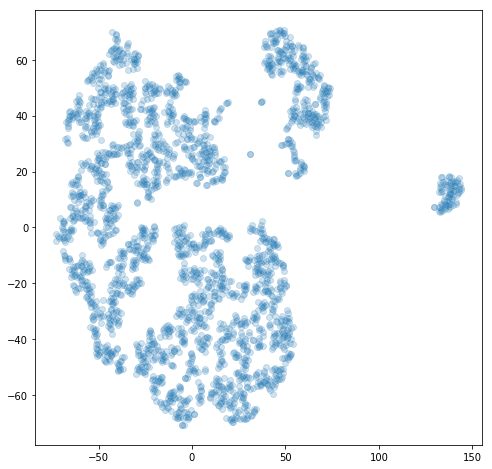

In [36]:
fig = plt.figure(figsize=(8,8))
plt.scatter(tsne_dist[:,0], tsne_dist[:,1],alpha = 0.20)
plt.show()

## Clustering

In [38]:
from utils import plot_clusters,plot_clusters_w_feat_plot,plot_clusters_w_feat_save, div_cluster, prep_report, rep_prep_report

skip if the patients are already clustered

In [37]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
clusterer.fit(tsne_dist)    
cls_labels = clusterer.labels_

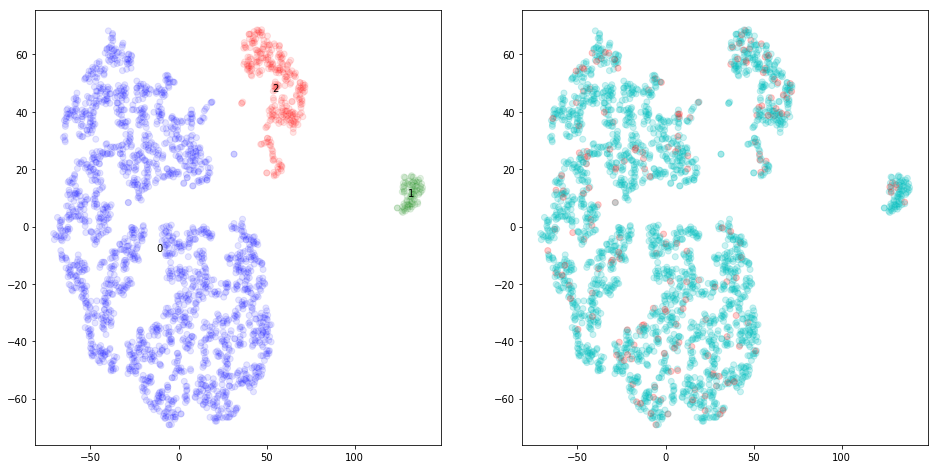

In [38]:
plot_clusters(tsne_dist, cls_labels, m_y)

To manually divide any given cluster if needed

/home/serkan/anaconda3/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


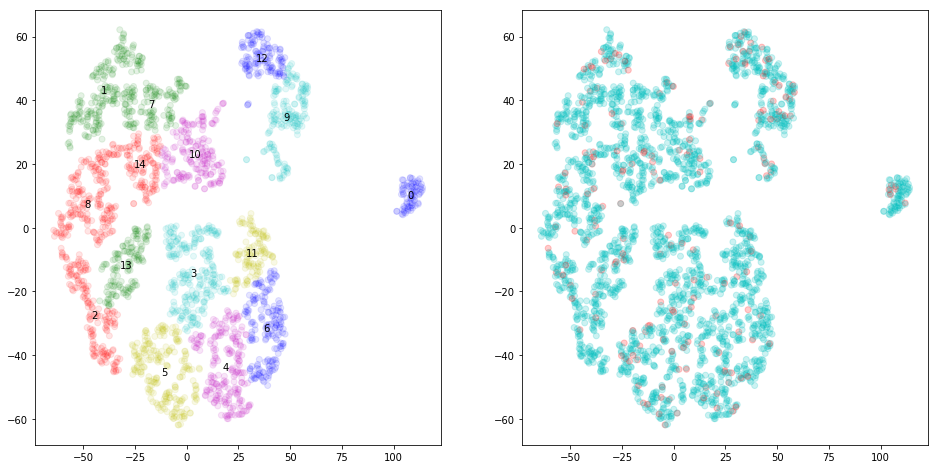

In [51]:
cls_labels_new = cls_labels
cls_labels_new = div_cluster(tsne_dist, cls_labels, clus_id_div=0,num_of_clus=14)
plot_clusters(tsne_dist, cls_labels_new,m_y)

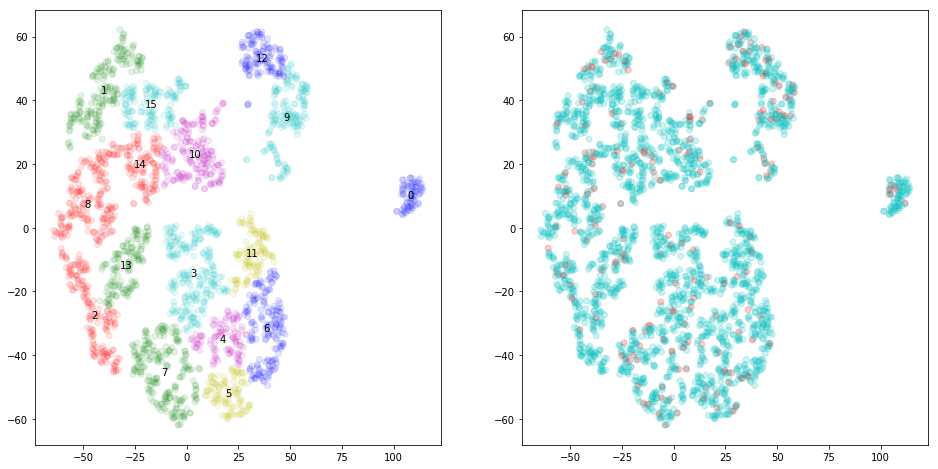

In [56]:
cls_labels_new2 = cls_labels_new
cls_labels_new2 = div_cluster(tsne_dist, cls_labels_new, clus_id_div=4,num_of_clus=2)
plot_clusters(tsne_dist, cls_labels_new2,m_y)

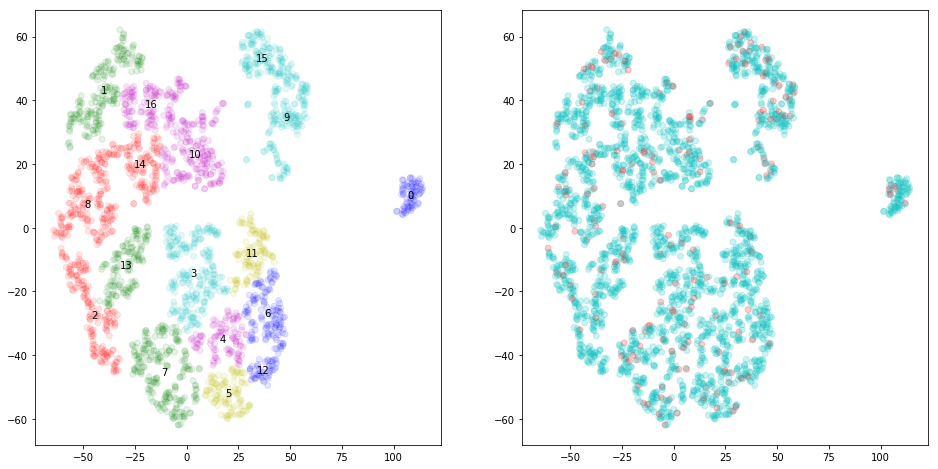

In [57]:
cls_labels_new2 = cls_labels_new2
cls_labels_new2 = div_cluster(tsne_dist, cls_labels_new2, clus_id_div=6,num_of_clus=2)
plot_clusters(tsne_dist, cls_labels_new2,m_y)

In [59]:
cls_labels_new2[cls_labels_new2==12]=5

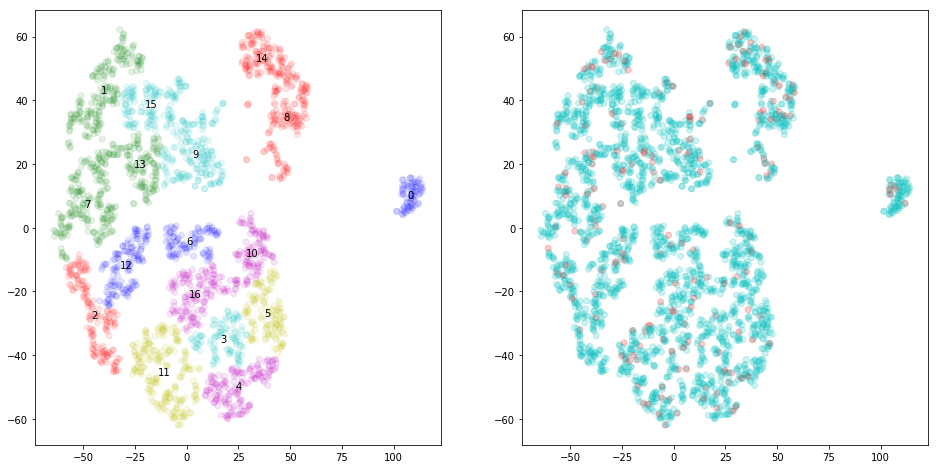

In [61]:
cls_labels_new2 = cls_labels_new2
cls_labels_new2 = div_cluster(tsne_dist, cls_labels_new2, clus_id_div=3,num_of_clus=2)
plot_clusters(tsne_dist, cls_labels_new2,m_y)

In [68]:
cls_labels_new = cls_labels_new2

In [62]:
np.savetxt(
    'cluster_assignments.csv',
    np.hstack((medData['ID #'].values[train_ind][:,None], tsne_dist,cls_labels_new2[:,None]))
)

## Reports

In [37]:
from utils import plot_clusters,plot_clusters_w_feat_plot,plot_clusters_w_feat_save, div_cluster, prep_report, rep_prep_report

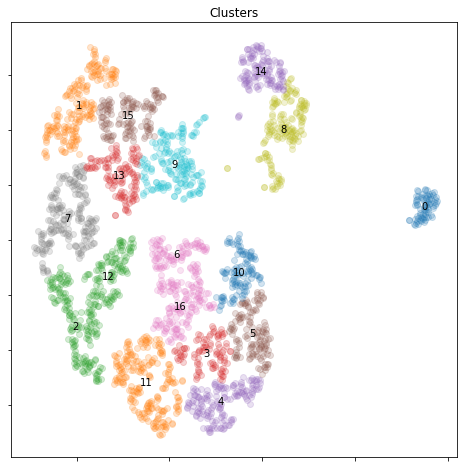

In [38]:
clustering_results = np.loadtxt('cluster_assignments.csv')
cls_labels_new = list(clustering_results[:,3].astype('int'))
plot_clusters(tsne_dist, cls_labels_new)

In [39]:
categs_json = read_enum_dict()

In [40]:
df_corr = pd.DataFrame(np.hstack((np.array(cls_labels_new)[:,None], train_x_f,train_x_c)), columns=['cluster']+list(medData_float.columns)+list(medData_categ.columns))

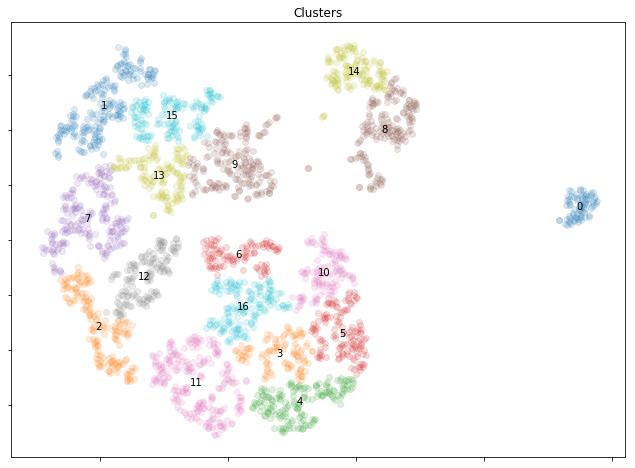

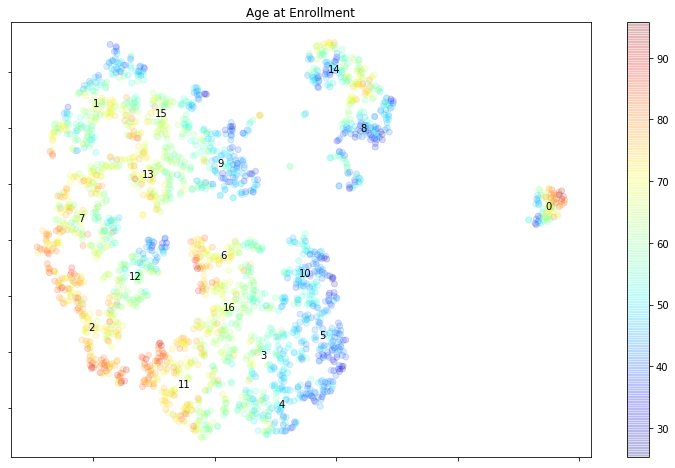

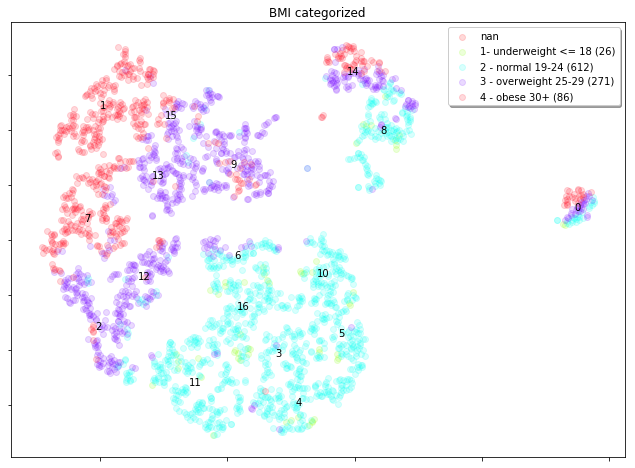

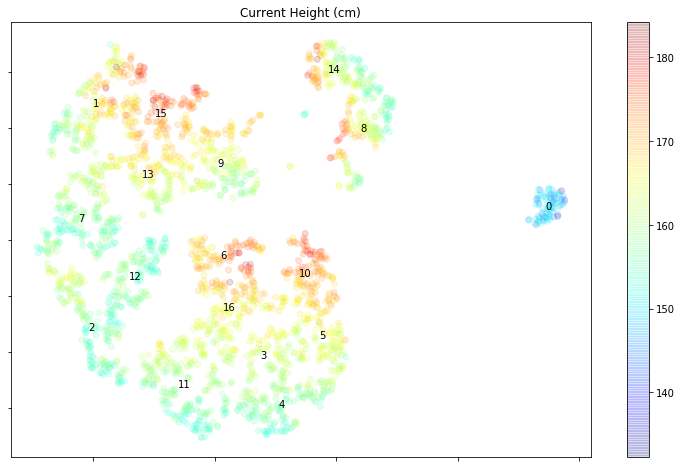

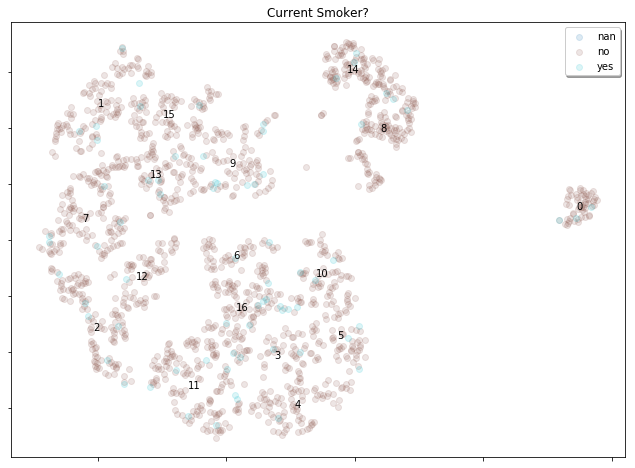

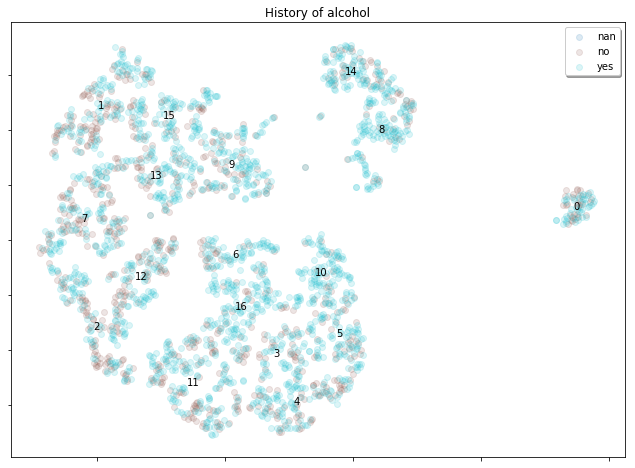

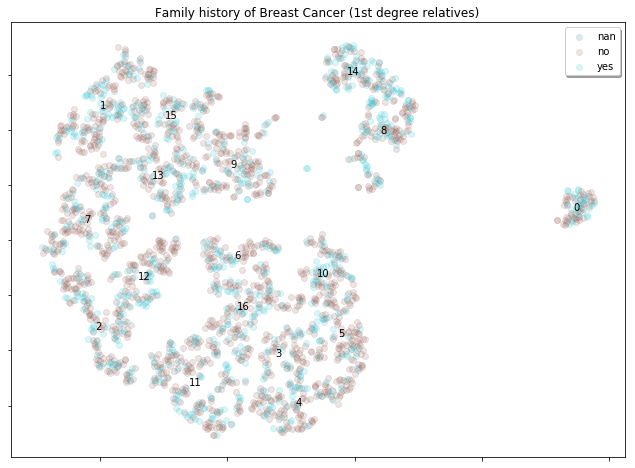

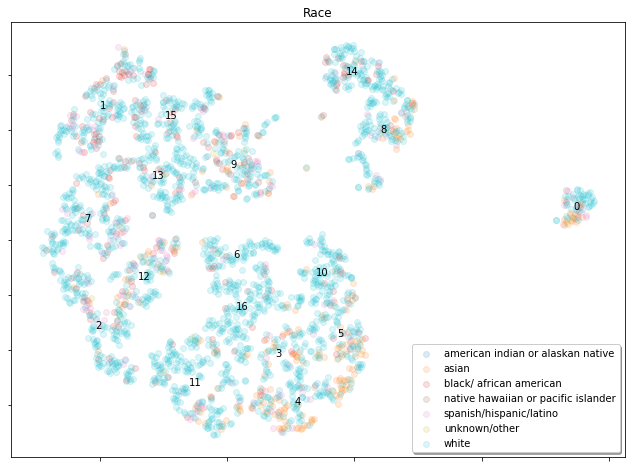

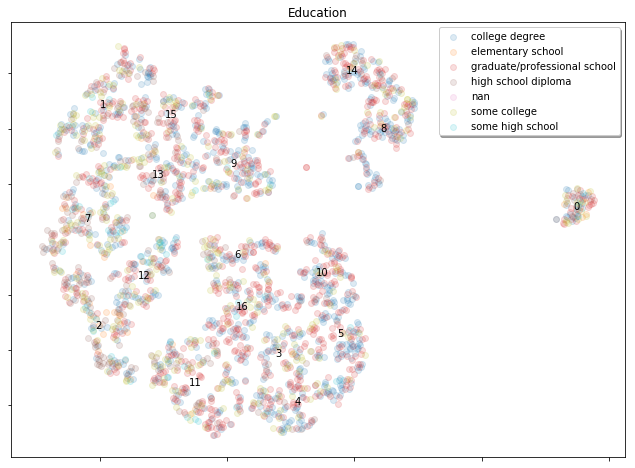

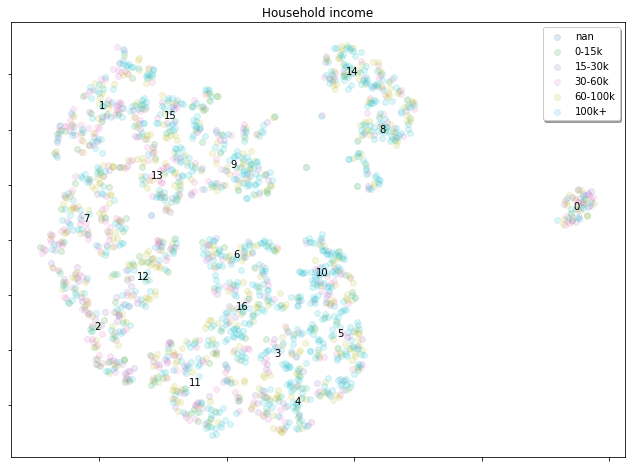

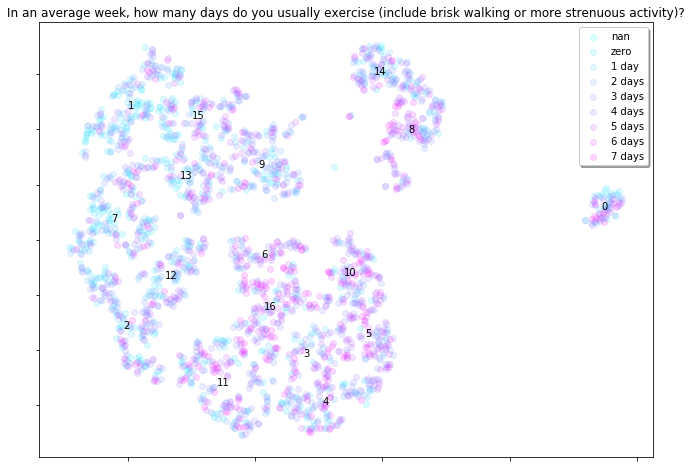

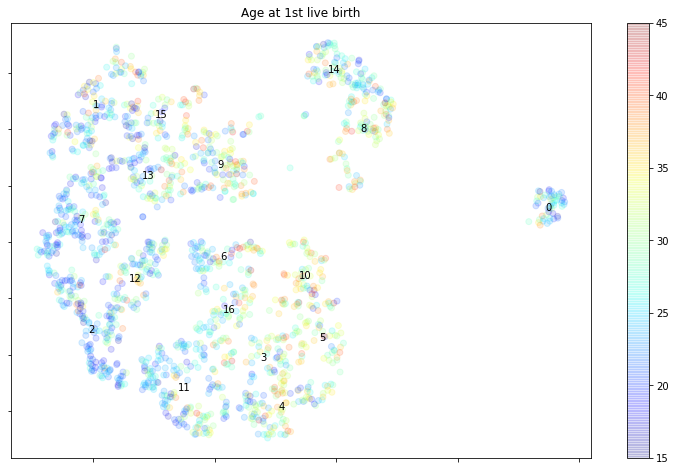

In [43]:
plot_clusters_w_feat_save(
    tsne_dist,
    cls_labels_new,
    .15,
    medData.iloc[train_ind], 
    'Age at Enrollment',
    'BMI categorized',
    'Current Height (cm)',
    'Current Smoker?','History of alcohol',
    'Family history of Breast Cancer (1st degree relatives)',
    'Race',
    'Education',
    'Household income',
    'In an average week, how many days do you usually exercise (include brisk walking or more strenuous activity)?',
    'Age at 1st live birth'
)

In [45]:
dummy_cols=[]
dummy_cols_map = {}
target_cols = []
for k in ['cluster']+list(medData_categ.columns):
    df_corr[k] = df_corr[k].astype('category')
for k in ['cluster']:
    for val in df_corr[k].cat.categories:
        df_corr[k+'|'+str(val)] = (df_corr[k] == val).astype('int32').astype('category')
        target_cols.append(k+'|'+str(val))
for k in list(medData_categ.columns):
    for val in df_corr[k].cat.categories:
        df_corr[k+'|'+str(val)] = (df_corr[k] == val).astype('int32').astype('category')
        dummy_cols.append(k+'|'+str(val))
        dummy_cols_map[k+'|'+str(val)] = k+'|'+str(val) + '|'+', '.join([a for a,b in categs_json[k].items() if b ==int(val)]) 

In [46]:
df_MI_X = df_corr[list(medData_float.columns) + dummy_cols]
discrete_flag = [False]*len(medData_float.columns) + [True]*len(dummy_cols)

### Calculating correlations for recurrence and triple negative cases

We calculate correlations using the deviations from cluster means of each feature

In [284]:
corr_with_selected_cols = df_MI_X.copy()
corr_with_selected_cols['triple_negative'] = m_y
corr_with_selected_cols['recurrence'] = recurrenceData.set_index('ID #').loc[medData['ID #']]['recurrence'].astype('float32').iloc[train_ind].values
corr_with_selected_cols = corr_with_selected_cols.astype('float32')
corr_with_selected_cols['cluster'] = cls_labels_new

In [285]:
grouped_means = corr_with_selected_cols.groupby('cluster', as_index=False).mean()
grouped_means=grouped_means[corr_with_selected_cols.columns]

In [286]:
def subs_cl_mean(pd_row):
    return pd_row - grouped_means.iloc[int(pd_row['cluster'])]

In [287]:
df_with_sub_mean = corr_with_selected_cols.apply(subs_cl_mean, axis=1)
df_with_sub_mean.drop('cluster',axis=1,inplace=True)
cov_with_sub_mean = np.sqrt(np.square(df_with_sub_mean).sum(axis=0) / df_with_sub_mean.shape[0])

In [299]:
cor_with_sub_mean_TN = ((df_with_sub_mean * df_with_sub_mean['triple_negative'].values[:,None]).sum(axis=0) / df_with_sub_mean.shape[0]) / (cov_with_sub_mean.values * cov_with_sub_mean.triple_negative)
corrs_final = cor_with_sub_mean_TN.sort_values().reset_index()
corrs_final['index'] = pd.Series([dummy_cols_map[k] if k in dummy_cols_map else k for k in corrs_final['index']]).values
corrs_final.to_csv('grouped_corr_analysis_tripleneg.csv',sep='\t')

In [300]:
cor_with_sub_mean_R = ((df_with_sub_mean * df_with_sub_mean['recurrence'].values[:,None]).sum(axis=0) / df_with_sub_mean.shape[0]) / (cov_with_sub_mean.values * cov_with_sub_mean.recurrence)
corrs_final = cor_with_sub_mean_R.sort_values().reset_index()
corrs_final['index'] = pd.Series([dummy_cols_map[k] if k in dummy_cols_map else k for k in corrs_final['index']]).values
corrs_final.to_csv('grouped_corr_analysis_recurrence.csv',sep='\t')

### Cluster statistics to understand the patient profiles

In [74]:
report_df = prep_report(df_MI_X, medData_float,df_corr,train_ind, dummy_cols,target_cols,discrete_flag, dummy_cols_map, quantile_1 =.25, quantile_2 = .75 )
report_df['categ_long'] = pd.Series([dummy_cols_map[k] if k in dummy_cols_map else '-' for k in report_df.index ],index=report_df.index)
rep_report_df = rep_prep_report(df_corr,rep_cols,target_cols,train_ind, categs_json, quantile_1 =.25, quantile_2 = .75)

In [75]:
report_final = report_df.append(rep_report_df)

In [76]:
report_final.to_csv('clusters_report.csv',sep='\t')

In [77]:
#((df_corr.cluster == 22) & (df_corr['Ashkenazi Jewish origin of grandparents?|1.0']==1)).sum() / (df_corr.cluster == 22).sum()

In [78]:
clus_mean_y = []
np_y = m_y.numpy()
for clus in np.unique(cls_labels_new):
    mean_y = np_y[cls_labels_new==clus].mean()
    clus_mean_y.append((clus,mean_y))

In [79]:
sorted(clus_mean_y,key=lambda x:x[1],reverse=True)

[(8, 0.12650602409638553),
 (14, 0.12598425196850394),
 (11, 0.1095890410958904),
 (7, 0.08866995073891626),
 (9, 0.08287292817679558),
 (0, 0.07792207792207792),
 (1, 0.07772020725388601),
 (4, 0.07643312101910828),
 (16, 0.06382978723404255),
 (10, 0.05982905982905983),
 (13, 0.05555555555555555),
 (6, 0.05263157894736842),
 (12, 0.05263157894736842),
 (3, 0.05),
 (2, 0.0440251572327044),
 (5, 0.03787878787878788),
 (15, 0.03676470588235294)]

for inspecting distribution on individual features

In [47]:
# for comparing distribution of categorical features with the population.
# we can group several categories 
for categ_c in set(cls_labels_new):
    categ_s = [f'BMI categorized|3.0', 'BMI categorized|2.0']
    perc_c = 100*sum([ (((df_corr.cluster == categ_c) & (df_corr[k]==1)).sum() / (df_corr.cluster == categ_c).sum()) for k in categ_s]      )
    perc_p =  100*sum([(df_corr[k]==1).mean() for k in categ_s] ) 
    print(f'{categ_c} | {perc_c:.3} | {perc_p:.3}')


0 | 66.2 | 53.7
1 | 1e+02 | 53.7
2 | 85.5 | 53.7
3 | 1.0 | 53.7
4 | 3.18 | 53.7
5 | 0.758 | 53.7
6 | 24.2 | 53.7
7 | 1e+02 | 53.7
8 | 14.5 | 53.7
9 | 97.8 | 53.7
10 | 0.855 | 53.7
11 | 1.83 | 53.7
12 | 93.2 | 53.7
13 | 99.2 | 53.7
14 | 96.9 | 53.7
15 | 97.1 | 53.7
16 | 0.0 | 53.7


In [48]:
# statistics for continuous features are already in the 
medData['Current Height (cm)'].mean()

162.41700655737606

In [49]:
# repetitive columns
cl_id = 6
for cl_id in set(cls_labels_new):
    print('--',cl_id,'--')
    col_name = 'relative_categ'
    col_vals = [4,3,2]
    for ii, group in enumerate(rep_cols):
        if not col_name in group[0][0].columns: continue
        flag_population = np.zeros(len(train_ind))
        flag_cluster = np.zeros(np.sum(cls_labels_new==cl_id))
        for block in group:
            if block is None: continue
            tmp_df = block[0].iloc[train_ind,:][col_name]
            for col_val in col_vals:
                flag_population = np.max((flag_population,(tmp_df==col_val).astype('int') ), axis=0 )
                flag_cluster = np.max((flag_cluster,(np.isclose(tmp_df[cls_labels_new==cl_id],col_val)).astype('int') ), axis=0 )
        print(f'{ii} | {flag_cluster.mean()*100:.3} | {flag_population.mean()*100:.3}')

-- 0 --
0 | 46.8 | 51.1
1 | 9.09 | 9.18
2 | 49.4 | 56.7
-- 1 --
0 | 52.8 | 51.1
1 | 9.84 | 9.18
2 | 56.0 | 56.7
-- 2 --
0 | 45.9 | 51.1
1 | 7.55 | 9.18
2 | 52.2 | 56.7
-- 3 --
0 | 45.0 | 51.1
1 | 4.0 | 9.18
2 | 52.0 | 56.7
-- 4 --
0 | 41.4 | 51.1
1 | 7.64 | 9.18
2 | 54.8 | 56.7
-- 5 --
0 | 45.5 | 51.1
1 | 8.33 | 9.18
2 | 50.0 | 56.7
-- 6 --
0 | 50.5 | 51.1
1 | 2.11 | 9.18
2 | 54.7 | 56.7
-- 7 --
0 | 48.8 | 51.1
1 | 10.3 | 9.18
2 | 55.7 | 56.7
-- 8 --
0 | 62.7 | 51.1
1 | 12.0 | 9.18
2 | 66.3 | 56.7
-- 9 --
0 | 49.7 | 51.1
1 | 8.84 | 9.18
2 | 53.6 | 56.7
-- 10 --
0 | 57.3 | 51.1
1 | 15.4 | 9.18
2 | 61.5 | 56.7
-- 11 --
0 | 53.0 | 51.1
1 | 7.76 | 9.18
2 | 52.5 | 56.7
-- 12 --
0 | 46.6 | 51.1
1 | 8.27 | 9.18
2 | 52.6 | 56.7
-- 13 --
0 | 54.0 | 51.1
1 | 8.73 | 9.18
2 | 57.9 | 56.7
-- 14 --
0 | 64.6 | 51.1
1 | 22.0 | 9.18
2 | 72.4 | 56.7
-- 15 --
0 | 52.2 | 51.1
1 | 5.88 | 9.18
2 | 64.0 | 56.7
-- 16 --
0 | 50.4 | 51.1
1 | 6.38 | 9.18
2 | 58.9 | 56.7
